In [36]:
!pip install openpyxl


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
#importing the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


In [37]:
import pandas as pd

file_path = "C:\\Users\\LENOVO\\Desktop\\Crediable assessment\\BI_Analyst_Case_Study_Data.xlsx"

xls = pd.ExcelFile(file_path, engine="openpyxl")  # Explicitly specify openpyxl
print(xls.sheet_names)


['Disbursements', 'Repayments']


In [38]:
# Load and inspect the first few rows of each sheet
df_disbursements = pd.read_excel(xls, sheet_name="Disbursements")
df_repayments = pd.read_excel(xls, sheet_name="Repayments")

# Display the first few rows of each sheet
df_disbursements.head(), df_repayments.head()


(                                         customer_id  disb_date   tenure  \
 0  91810ca1aa097db79f050f38e9946fa5482b4e28c925e2... 2024-03-19  14 days   
 1  42ca06e6fe1ff9803e82a5c20184671b54090e488f78d6... 2024-03-19   7 days   
 2  b23747f53af805e18ad16a4ef235b6642d88f9134644ff... 2024-03-19   7 days   
 3  1bd32f9b083fc6ddfffd65730fbfa66654fa76a19b0b0e... 2024-03-19  14 days   
 4  e7cfbaa97ba7702c52df5f1dddba54bd26923ebad945f1... 2024-03-19   7 days   
 
                         account_num  loan_amount  loan_fee  
 0  3O66YENWELA6E2H1R9YLX0LDZNOMNHD4          360      43.2  
 1  6XWHXKKR1W2HIA8I0V75PZFZBXUUGSVO           70       7.0  
 2  OCGK3RJZ91A999VXD4VB3LATPSME3J5L         3500     350.0  
 3  9X3Q682DOR7927IMMJLFHBGP0RP7YF5C         3500     420.0  
 4  AQH88NNF8S76MGJL4J4ULEAE18O0KLWH          120      12.0  ,
                          date_time  \
 0  27-JUN-24 07.16.36.000000000 AM   
 1  27-JUN-24 05.26.50.000000000 PM   
 2  27-JUN-24 06.45.40.000000000 PM   
 3  27-

In [39]:
# Convert date columns to datetime format
df_disbursements["disb_date"] = pd.to_datetime(df_disbursements["disb_date"])
df_repayments["date_time"] = pd.to_datetime(df_repayments["date_time"], format="%d-%b-%y %I.%M.%S.%f %p")

# Aggregate total disbursements per month
disbursements_monthly = df_disbursements.groupby(df_disbursements["disb_date"].dt.to_period("M")).agg(
    {"loan_amount": "sum", "loan_fee": "sum"}
).rename(columns={"loan_amount": "Total_Disbursed", "loan_fee": "Total_Loan_Fees"})

# Aggregate total repayments per month
repayments_monthly = df_repayments.groupby(df_repayments["date_time"].dt.to_period("M")).agg(
    {"amount": "sum"}
).rename(columns={"amount": "Total_Repaid"})

# Merge data on monthly periods
df_profit_loss = disbursements_monthly.join(repayments_monthly, how="outer").fillna(0)

# Compute Profit/Loss per month
df_profit_loss["Profit_Loss"] = df_profit_loss["Total_Repaid"] - (df_profit_loss["Total_Disbursed"] + df_profit_loss["Total_Loan_Fees"])

# Convert period index to datetime index for ARIMA modeling
df_profit_loss.index = df_profit_loss.index.to_timestamp()

# Display processed data
df_profit_loss.head()


,Total_Disbursed,Total_Loan_Fees,Total_Repaid,Profit_Loss
disb_date,,,,
2024-01-01,3179535,408502.15,3424762.01,-163275.14
2024-02-01,3430755,442186.79,3603851.65,-269090.14
2024-03-01,3934501,508657.31,4154367.32,-288790.99
2024-04-01,3936530,506603.30,4253738.69,-189394.61
2024-05-01,4018499,521668.75,4466721.70,-73446.05


In [40]:
# Display the first few values of the "date_time" column to determine the format
df_repayments["date_time"].head(10)


0   2024-06-27 07:16:36
1   2024-06-27 17:26:50
2   2024-06-27 18:45:40
3   2024-06-27 13:24:57
4   2024-06-27 13:31:44
5   2024-06-27 15:26:42
6   2024-06-27 13:20:04
7   2024-06-27 09:05:37
8   2024-06-04 08:01:56
9   2024-06-04 19:55:36
Name: date_time, dtype: datetime64[ns]

In [45]:
# Ensure 'date_time' is a string before slicing
df_repayments["date_time"] = df_repayments["date_time"].astype(str).str.slice(0, 22)

# Convert to datetime format
df_repayments["date_time"] = pd.to_datetime(df_repayments["date_time"], errors="coerce", infer_datetime_format=True)

# Check if the conversion worked
print(df_repayments["date_time"].dtype)
print(df_repayments["date_time"].head())


datetime64[ns]
0   2024-06-27 07:16:36
1   2024-06-27 17:26:50
2   2024-06-27 18:45:40
3   2024-06-27 13:24:57
4   2024-06-27 13:31:44
Name: date_time, dtype: datetime64[ns]


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12344\3793604038.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_repayments["date_time"] = pd.to_datetime(df_repayments["date_time"], errors="coerce", infer_datetime_format=True)


In [51]:
# Aggregate total disbursements per month
disbursements_monthly = df_disbursements.groupby(df_disbursements["disb_date"].dt.to_period("M")).agg(
    {"loan_amount": "sum", "loan_fee": "sum"}
).rename(columns={"loan_amount": "Total_Disbursed", "loan_fee": "Total_Loan_Fees"})

# Merge repayments and disbursements data
df_profit_loss = disbursements_monthly.join(repayments_monthly, how="outer").fillna(0)

# Compute Profit/Loss per month
df_profit_loss["Profit_Loss"] = df_profit_loss["Total_Repaid"] - (df_profit_loss["Total_Disbursed"] + df_profit_loss["Total_Loan_Fees"])

# Convert period index to datetime index for ARIMA modeling
df_profit_loss.index = df_profit_loss.index.to_timestamp()

# Display processed dataset
df_profit_loss.head()


,Total_Disbursed,Total_Loan_Fees,Total_Repaid,Profit_Loss
disb_date,,,,
2024-01-01,3179535,408502.15,3424762.01,-163275.14
2024-02-01,3430755,442186.79,3603851.65,-269090.14
2024-03-01,3934501,508657.31,4154367.32,-288790.99
2024-04-01,3936530,506603.30,4253738.69,-189394.61
2024-05-01,4018499,521668.75,4466721.70,-73446.05


In [54]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Select the Profit/Loss column for time-series modeling
profit_loss_series = df_profit_loss["Profit_Loss"]

# **Step 1: Check for Stationarity using ADF Test**
# **Step 1: Check for Constant Values**
if profit_loss_series.nunique() == 1:
    print("All values in Profit/Loss series are constant. ARIMA cannot be applied.")
else:
    # **Step 2: Check for Stationarity using ADF Test**
    is_stationary = check_stationarity(profit_loss_series)

    # **Step 3: Determine Order of Differencing (d) if needed**
    def find_optimal_d(series, max_diff=3):
        for d in range(1, max_diff+1):  # Start differencing from d=1
            diff_series = series.diff(d).dropna()
            p_value = sm.tsa.adfuller(diff_series)[1]
            print(f"ADF p-value for d={d}: {p_value}")
            if p_value < 0.05:
                print(f"Optimal differencing order (d) found: {d}")
                return d
        print("No stationarity achieved, consider transforming data.")
        return max_diff

    d_value = find_optimal_d(profit_loss_series)


ADF Statistic: 1.7295590031802075
p-value: 0.9981985802978702
The series is NOT stationary, differencing is needed.
ADF p-value for d=1: 0.5469729746531432
ADF p-value for d=2: 0.3860541132484372
ADF p-value for d=3: 0.95386976392954
No stationarity achieved, consider transforming data.


In [56]:
import numpy as np

# Shift data by adding a constant to make all values positive
shift_constant = abs(profit_loss_series.min()) + 1  # Ensure all values are >0
profit_loss_series_shifted = profit_loss_series + shift_constant

# Apply log transformation
profit_loss_series_log = np.log1p(profit_loss_series_shifted)

# Re-run ADF test
is_stationary_log = check_stationarity(profit_loss_series_log)

# If still non-stationary, find optimal differencing
if not is_stationary_log:
    d_value = find_optimal_d(profit_loss_series_log)

# Convert forecasts back by reversing the shift
def reverse_shift(log_forecast, shift_constant):
    return np.expm1(log_forecast) - shift_constant


ADF Statistic: -1.854267389689633
p-value: 0.353871298025639
The series is NOT stationary, differencing is needed.
ADF p-value for d=1: 2.61030004613849e-07
Optimal differencing order (d) found: 1


In [72]:
# Define ARIMA Model with (p=1, d=1, q=1)
p, q = 1, 1  
model = ARIMA(profit_loss_series_log, order=(0, 1, 1)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:            Profit_Loss   No. Observations:                    8
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -20.946
Date:                Fri, 21 Mar 2025   AIC                             45.892
Time:                        15:12:31   BIC                             45.784
Sample:                    01-01-2024   HQIC                            44.555
                         - 08-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6499      0.694     -0.937      0.349      -2.010       0.710
sigma2        21.5079     15.313      1.405      0.160      -8.506      51.522
Ljung-Box (L1) (Q):                   0.01   Jarque-

In [63]:
# Forecast next 3 months
forecast_steps = 3
forecast_log = fitted_model.forecast(steps=forecast_steps)

In [65]:
print(forecast_log)


2024-09-01    11.861135
2024-10-01    11.182589
2024-11-01    10.995156
Freq: MS, Name: predicted_mean, dtype: float64


In [66]:
# Convert forecast back to original scale
forecast_original_scale = np.expm1(forecast_log) - shift_constant

# Create DataFrame for final forecasted values
forecast_df = pd.DataFrame({"Forecast_Profit_Loss": forecast_original_scale}, index=forecast_log.index)

# Print the final forecasted profit/loss
print(forecast_df)


            Forecast_Profit_Loss
2024-09-01        -147140.091610
2024-10-01        -216924.812977
2024-11-01        -229208.159623


In [67]:
# Ensure shift_constant is correctly defined
shift_constant = abs(profit_loss_series.min()) + 1 if 'shift_constant' not in locals() else shift_constant

# Convert forecast back to original scale
forecast_original_scale = np.expm1(forecast_log) - shift_constant

# Create DataFrame for final forecasted values
forecast_df = pd.DataFrame({"Forecast_Profit_Loss": forecast_original_scale}, index=forecast_log.index)

# Print the final forecasted profit/loss values
print("Final Forecasted Profit/Loss Values:")
print(forecast_df)


Final Forecasted Profit/Loss Values:
            Forecast_Profit_Loss
2024-09-01        -147140.091610
2024-10-01        -216924.812977
2024-11-01        -229208.159623


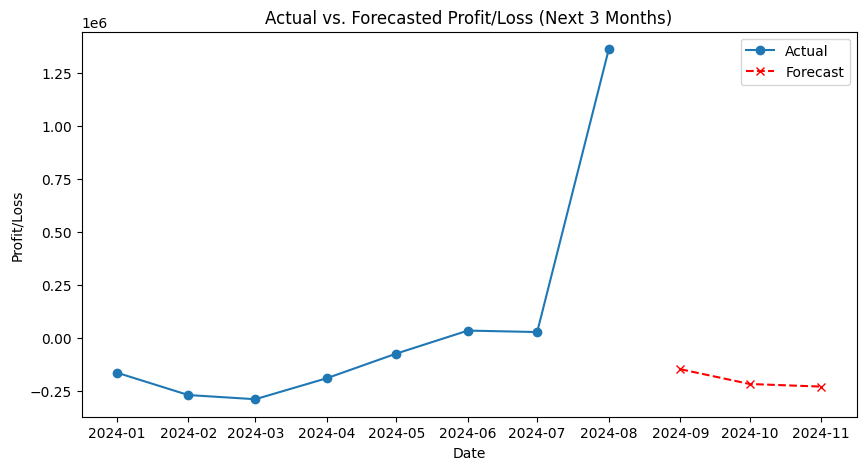

In [71]:
# **Step 3: Plot actual vs. forecasted profit/loss**
plt.figure(figsize=(10, 5))
plt.plot(df_profit_loss.index, df_profit_loss["Profit_Loss"], label="Actual", marker="o")
plt.plot(forecast_df.index, forecast_df["Forecast_Profit_Loss"], label="Forecast", marker="x", linestyle="dashed", color='red')
plt.xlabel("Date")
plt.ylabel("Profit/Loss")
plt.title("Actual vs. Forecasted Profit/Loss (Next 3 Months)")
plt.legend()
plt.show()
